In [1]:
library(tidyverse)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [3]:
library(tidymodels)
install.packages("GGally")
install.packages("kknn")
library(kknn)
library(GGally)
set.seed(3)

also installing the dependencies ‘labelled’, ‘broom.helpers’, ‘ggplot2’, ‘ggstats’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



In [4]:
cbb <- read_csv("https://raw.githubusercontent.com/naw333/College-Basketball-Data-Science/main/cbb.csv") 

Rows: 3523 Columns: 24
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (4): TEAM, CONF, POSTSEASON, SEED
dbl (20): G, W, ADJOE, ADJDE, BARTHAG, EFG_O, EFG_D, TOR, TORD, ORB, DRB, FT...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


#The training set will be used to perform a 5-fold cross-validation to select the k value 
#that optimizes the classifiers' performance based on the accuracy of the classifier. 
#The performance of the classifier will be tested using the test set, 
#then a new set of observations for basketball teams will be classified using the trained classifier. 
#The correlation coefficient will be calculated between each predictor variable and POSTSEASON, 
#and the result of this will be visualized as a bar graph.

### Data Analysis

The data analysis includes these following steps:
1. Selecting predictors with forward selection;
2. Visualizing selected predictor variables;
3. Selecting a k-value; and
4. Evaluating the tuned knn classification model.

### 1. Selecting predictors with forward selection

In [6]:
cbb_modified <- cbb|> filter(POSTSEASON != "N/A")|>mutate(PERC= W/G) |> mutate(POSTSEASON=as_factor(POSTSEASON))|> mutate(TEAM = as_factor(TEAM))

cbb_short <- cbb_modified|> select(
                          PERC,
                          ADJOE,
                          ADJDE,
                          BARTHAG,
                          EFG_O,
                          EFG_D,
                          TOR,
                          TORD,
                          ORB,
                          DRB,
                          FTR,
                          ADJ_T,
                          POSTSEASON,
                          )
head(cbb_short)
cbb_split <- initial_split(cbb_short, prop = 0.75, strata = POSTSEASON)
cbb_train <- training(cbb_split)
cbb_test <- testing(cbb_split)
cbb_summ <- summarize(cbb_train, team_count = nrow(cbb_train), mean_ADJOE = mean(ADJOE), mean_ADJDE = mean(ADJDE), mean_ADJ_T = mean(ADJ_T), mean_ORB = mean(ORB), mean_TOR = mean(TOR), mean_PERC = mean(PERC))
cbb_summ

PERC      ADJOE ADJDE BARTHAG EFG_O EFG_D TOR  TORD ORB  DRB  FTR  ADJ_T
1 0.8250000 123.3 94.9  0.9531  52.6  48.1  15.4 18.2 40.7 30.0 32.3 71.7 
2 0.9000000 129.1 93.6  0.9758  54.8  47.7  12.4 15.8 32.1 23.7 36.2 59.3 
3 0.8250000 114.4 90.4  0.9375  53.9  47.7  14.0 19.5 25.5 24.9 30.7 65.9 
4 0.8157895 115.2 85.2  0.9696  53.5  43.0  17.7 22.8 27.4 28.7 32.9 67.5 
5 0.9487179 117.8 86.3  0.9728  56.6  41.1  16.2 17.1 30.0 26.2 39.0 71.5 
6 0.7250000 117.2 96.2  0.9062  49.9  46.0  18.1 16.1 42.0 29.7 51.8 65.9 
  POSTSEASON
1 2ND       
2 2ND       
3 2ND       
4 2ND       
5 2ND       
6 2ND

team_count mean_ADJOE mean_ADJDE mean_ADJ_T mean_ORB mean_TOR mean_PERC
1 509        111.366    96.46837   67.72711   31.36739 17.4778  0.7263782

In [7]:
cbb_subset <- cbb_short|> select(POSTSEASON,
                                 ADJOE,
                                 ADJDE,
                                 BARTHAG,
                                 DRB,
                                 EFG_D,
                                 EFG_O,
                                 FTR,
                                 TOR,
                                 ORB)
names <- colnames(cbb_subset|>select(-POSTSEASON))
head(cbb_subset)

example_formula <- paste("POSTSEASON", "~", paste(names,collapse="+"))
example_formula

POSTSEASON ADJOE ADJDE BARTHAG DRB  EFG_D EFG_O FTR  TOR  ORB 
1 2ND        123.3 94.9  0.9531  30.0 48.1  52.6  32.3 15.4 40.7
2 2ND        129.1 93.6  0.9758  23.7 47.7  54.8  36.2 12.4 32.1
3 2ND        114.4 90.4  0.9375  24.9 47.7  53.9  30.7 14.0 25.5
4 2ND        115.2 85.2  0.9696  28.7 43.0  53.5  32.9 17.7 27.4
5 2ND        117.8 86.3  0.9728  26.2 41.1  56.6  39.0 16.2 30.0
6 2ND        117.2 96.2  0.9062  29.7 46.0  49.9  51.8 18.1 42.0

[1] "POSTSEASON ~ ADJOE+ADJDE+BARTHAG+DRB+EFG_D+EFG_O+FTR+TOR+ORB"

In [8]:
accuracies <- tibble(size = integer(),
                     model_string = character(),
                     accuracy = numeric())
#create model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular",
                             neighbors = tune()) |>
        set_engine("kknn") |>
        set_mode("classification")

#create 5-fold cross validation object 
cbb_vfold <- vfold_cv(cbb_subset, v = 5, strata = POSTSEASON)

#store the total number of predictors
n_total <- length(names)

#store selected predictors 
selected <- c()

#for every size form 1 to the toal number of predictors
for (i in 1:n_total) {
    #for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)){
        # create model string for this combinatin of predictors
        preds_new <- c(selected,names[[j]])
        model_string <- paste ("POSTSEASON", "~", paste(preds_new, collapse = "+"))

        #create a recipe from the model string 
        cbb_recipe <- recipe(as.formula(model_string),
                            data = cbb_subset) |>
                        step_scale(all_predictors())|>
                        step_center(all_predictors())

        #tune the KNN classifier with there predictors,
        #and collect the accuracy for the best K
        acc <- workflow()|>
            add_recipe(cbb_recipe) |>
            add_model(knn_spec) |>
            tune_grid(resamples = cbb_vfold, grid = 10) |>
            collect_metrics() |>
            filter(.metric == "accuracy") |>
            summarize(mx = max(mean))
        acc <- acc$mx |> unlist()
    
        #add this result to the dataframe 
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies |>
        add_row(size = i,
                model_string = models[[jstar]],
                accuracy = accs[[jstar]])
        selected <- c(selected, names[[jstar]])
        names <- names[-jstar]
}
accuracies

! Fold4: internal:
  There were 9 warnings in `dplyr::summarise()`.
  The first warning was:
  ℹ In argument: `.estimate = metric_fn(...)`.
  ℹ In group 1: `neighbors = 1`.
  Caused by warning:
  ! No observations were detected in `truth` for level(s): 'Ch...
  Computation will proceed by ignoring those levels.
  ℹ Run `dplyr::last_dplyr_warnings()` to see the 8 r...

! Fold4: internal:
  There were 9 warnings in `dplyr::summarise()`.
  The first warning was:
  ℹ In argument: `.estimate = metric_fn(...)`.
  ℹ In group 1: `neighbors = 1`.
  Caused by warning:
  ! No observations were detected in `truth` for level(s): 'Ch...
  Computation will proceed by ignoring those levels.
  ℹ Run `dplyr::last_dplyr_warnings()` to see the 8 r...

! Fold4: internal:
  There were 9 warnings in `dplyr::summarise()`.
  The first warning was:
  ℹ In argument: `.estimate = metric_fn(...)`.
  ℹ In group 1: `neighbors = 2`.
  Caused by warning:
  ! No observations were detected in `truth` for level(s): 'Ch..

size model_string                                                 accuracy 
1 1    POSTSEASON ~ BARTHAG                                         0.4999565
2 2    POSTSEASON ~ BARTHAG+ORB                                     0.5016879
3 3    POSTSEASON ~ BARTHAG+ORB+ADJOE                               0.4884738
4 4    POSTSEASON ~ BARTHAG+ORB+ADJOE+DRB                           0.5074076
5 5    POSTSEASON ~ BARTHAG+ORB+ADJOE+DRB+ADJDE                     0.5192932
6 6    POSTSEASON ~ BARTHAG+ORB+ADJOE+DRB+ADJDE+TOR                 0.5044759
7 7    POSTSEASON ~ BARTHAG+ORB+ADJOE+DRB+ADJDE+TOR+EFG_O           0.4999983
8 8    POSTSEASON ~ BARTHAG+ORB+ADJOE+DRB+ADJDE+TOR+EFG_O+EFG_D     0.4823719
9 9    POSTSEASON ~ BARTHAG+ORB+ADJOE+DRB+ADJDE+TOR+EFG_O+EFG_D+FTR 0.4737652

From the results of the forward selection process, we concluded that the best recipe is:
POSTSEASON ~ BARTHAG+ORB+ADJOE+DRB+ADJDE
(add up implications in basketball)

In [17]:
# Select only relevant predictors.
#BARTHAG+ORB+ADJOE+DRB+ADJDE
PREDICTOR_VARIABLES <- c("BARTHAG", "DRB", "ADJDE", "ORB", "ADJOE")

cbb_training_data_predictor_selected <- cbb_train |>
    select(POSTSEASON, all_of(PREDICTOR_VARIABLES))

head(cbb_training_data_predictor_selected)

POSTSEASON BARTHAG DRB  ADJDE ORB  ADJOE
1 2ND        0.9531  30.0 94.9  40.7 123.3
2 Champions  0.9736  25.4 89.9  30.4 123.0
3 Champions  0.9703  29.4 90.9  28.2 123.1
4 Champions  0.9725  27.1 94.1  29.6 128.4
5 Champions  0.9171  32.8 91.3  30.4 112.5
6 Champions  0.9743  33.3 84.5  38.2 115.9

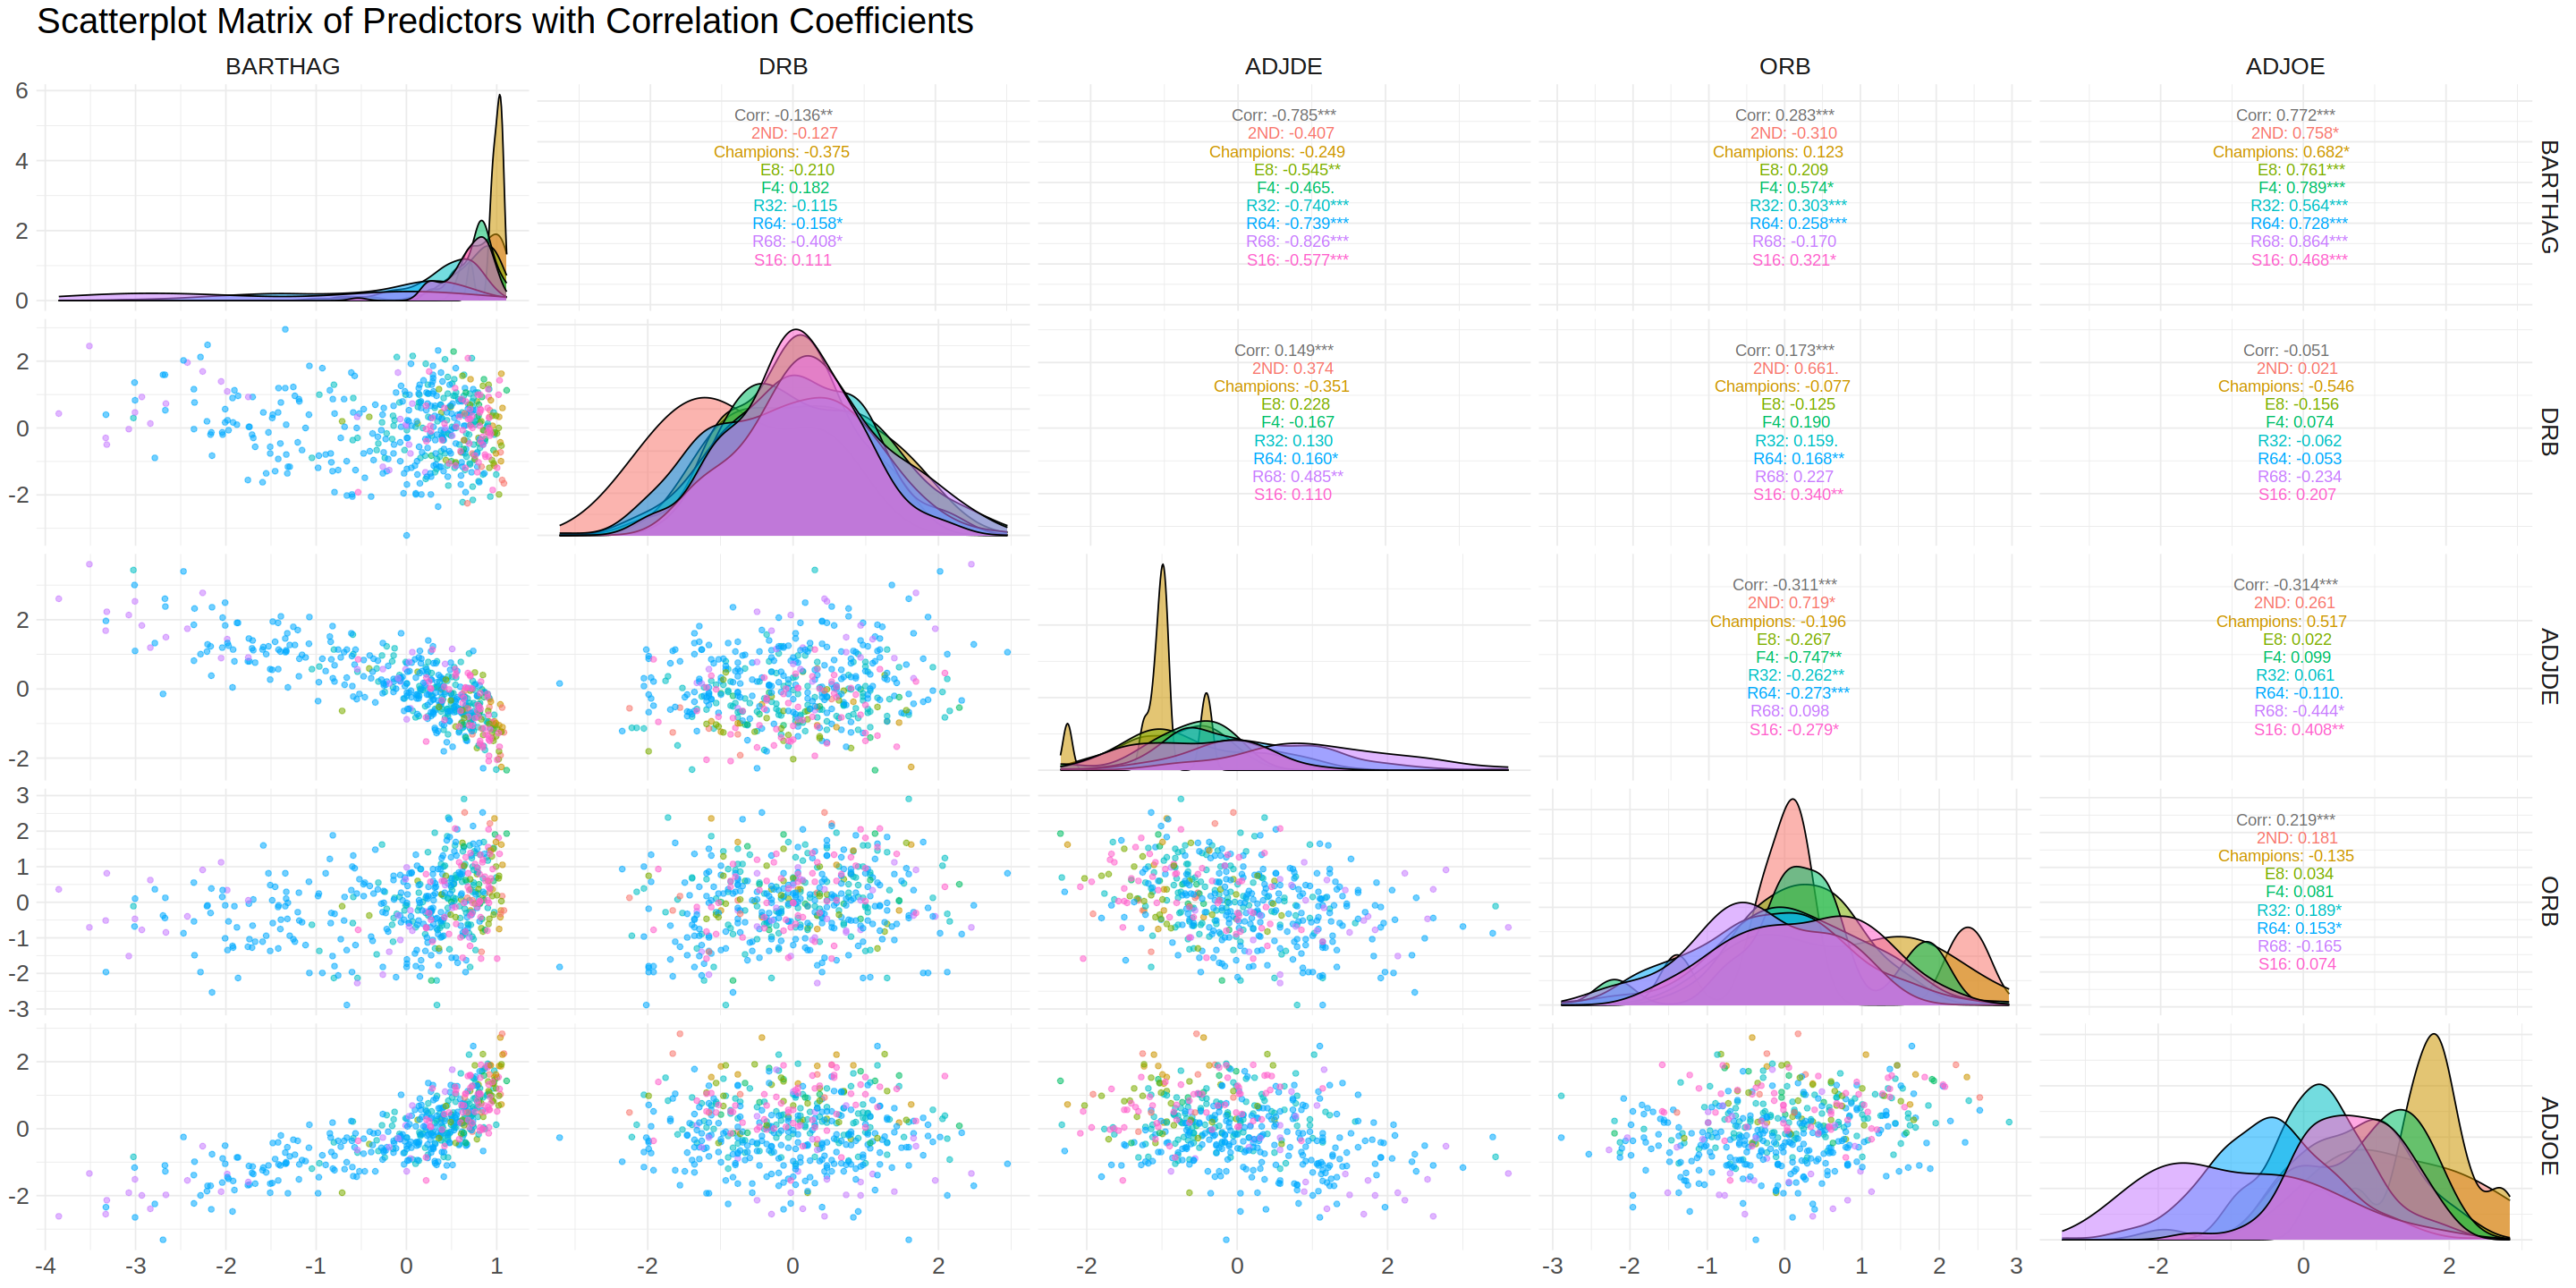

In [11]:
options(repr.plot.height = 12, repr.plot.width = 24)

cbb_training_data_predictor_selected |>
    # Normalize the data.
    select(all_of(PREDICTOR_VARIABLES)) |>
    scale() |>
    bind_cols(POSTSEASON = cbb_training_data_predictor_selected$POSTSEASON) |>

    # Create a scatterplot matrix.
    ggpairs(aes(alpha = 0.4, colour = POSTSEASON), columns = 1:length(PREDICTOR_VARIABLES)) +
        labs(title = "Scatterplot Matrix of Predictors with Correlation Coefficients") +
        theme_minimal() +
        theme(text = element_text(size = 20))

In [14]:
# options(repr.plot.height = 12, repr.plot.width = 24)

# cbb_training_data_predictor_selected |>
#     # Create a parallel coordinates plot.
#     ggparcoord(alpha = 0.5, columns = 2:ncol(cbb_training_data_predictor_selected),
#                groupColumn = "POSTSEASON", splineFactor = 9, order = "anyClass", scale = "centerObs") + 
#         labs(title = "Parallel Coordinates Plot of Predictors",
#              x = "Value", y = "Variable", color = "Round") +
#         guides(color = guide_legend(override.aes = list(size = 10))) +
#         theme_minimal() +
#         theme(text = element_text(size = 20), legend.pos = "top")

! Fold3: internal:
  There were 100 warnings in `dplyr::summarise()`.
  The first warning was:
  ℹ In argument: `.estimate = metric_fn(...)`.
  ℹ In group 1: `neighbors = 1`.
  Caused by warning:
  ! No observations were detected in `truth` for level(s): 'Ch...
  Computation will proceed by ignoring those levels.
  ℹ Run `dplyr::last_dplyr_warnings()` to see the 99 ...



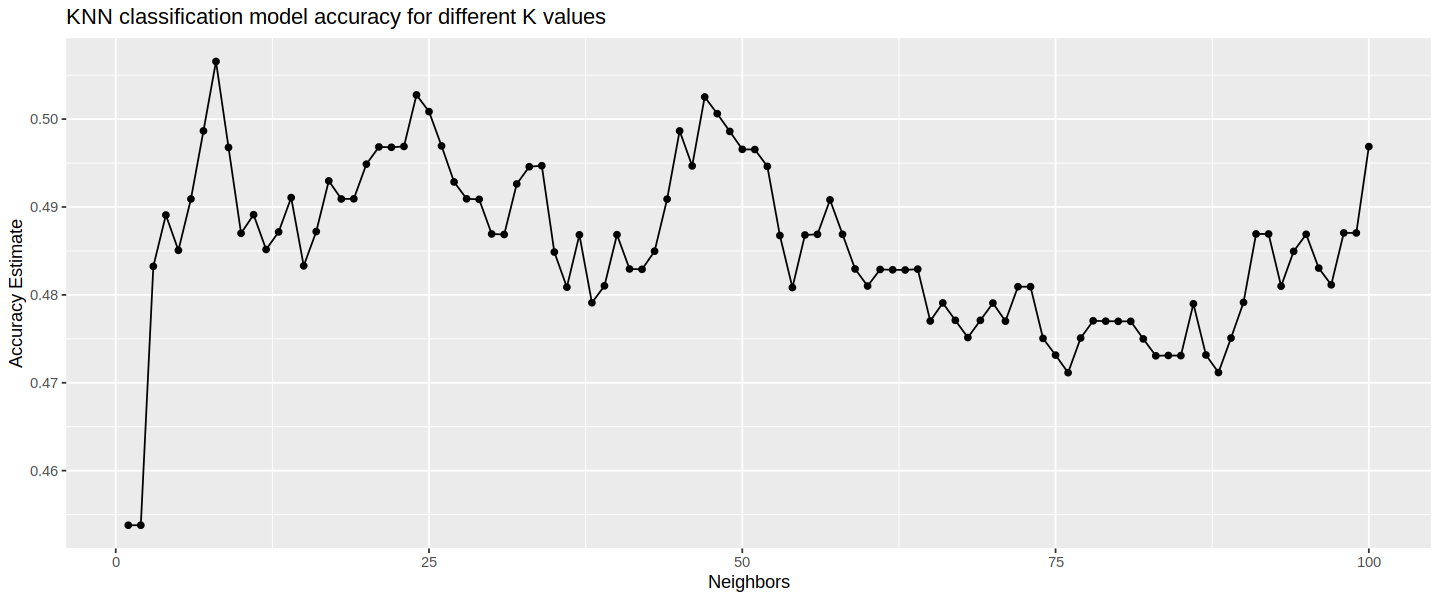

In [18]:
options(repr.plot.height = 5, repr.plot.width = 12)
basket_recipe <- recipe(POSTSEASON ~ BARTHAG+ORB+ADJOE+DRB+ADJDE, data = cbb_train) |>
                step_scale(all_predictors()) |>
                step_center(all_predictors()) 

basket_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
          set_engine("kknn") |>
          set_mode("classification")
    
basket_vfold <- vfold_cv(cbb_train, v = 5, strata = POSTSEASON)

    basket_workflow <- workflow() |>
          add_recipe(basket_recipe) |>
          add_model(basket_spec)

k_vals <- tibble(neighbors = seq(1:100))

basket_results <- basket_workflow|>
                        tune_grid(resamples = basket_vfold, grid = k_vals)|>
                        collect_metrics()

accuracies <- basket_results|> filter(.metric == "accuracy")
cross_val_plot <- accuracies|>ggplot(aes(x = neighbors, y=mean)) + 
                                    geom_point()+
                                    geom_line()+
                                    labs(title = "KNN classification model accuracy for different K values",
                                         x = "Neighbors", 
                                         y = "Accuracy Estimate")
cross_val_plot